In [ ]:
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
import pickle
from scipy import sparse

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords


## 1. Предобработать собранный корпус (датасет новостей): удаление знаков препинания и лишних символов, токенизация, приведение к нормальной форме, удаление стоп-слов

In [2]:
def preprocessing(path):
    print('Current working directory:', os.getcwd())
    texts = []
    targets = []
    punct = '".#$%&\'*+,-/:;<=>@[\\]^_`{|}~!'
    #seed = 111

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    lemmatizer = WordNetLemmatizer()

    with open(path) as filename:
        data = json.load(filename)
        for article in data['catalog']:
            raw_text = article['text']
            targets.append(article['category'])
            for p in punct:
                if p in raw_text:
                    raw_text = raw_text.replace(p, '')
                    raw_text = raw_text.replace(',', '')
            lower_text = raw_text.lower()
            my_stopwords = [w.casefold() for w in stopwords.words()]
            texts_lem = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(lower_text) if
                            not w.casefold() in my_stopwords]
            texts.append(' '.join(texts_lem))
            

    #labels_ = np.array(np.array(labels_, dtype=float))
    #labels_ = np.transpose(labels_)
    print('Preprocessing is done.\n')
    # if len(texts) == len(labels_):
    #     random.Random(seed).shuffle(texts)
    #     random.Random(seed).shuffle(labels_)
    # else:
    #     return 0
    return np.array(texts), np.array(targets)

In [7]:
texts, targets = preprocessing('../dataset/news.json')

Current working directory: e:\Projects\nlp_labs\lab2
Preprocessing is done.



Сохранение и загрузка файлов после препроцессинга

In [27]:
with open('data/processed.pickle', 'wb') as f1, open('data/targets.pickle', 'wb') as f2:
    pickle.dump(texts, f1)
    pickle.dump(targets, f2)

In [2]:
with open('data/processed.pickle', 'rb') as f1, open('data/targets.pickle', 'rb') as f2:
    texts = pickle.load(f1)
    targets = pickle.load(f2)

## 2. Векторизовать тексты (CountVectorizer и/или TfIdfVectorizer) 

Я выбрал TfidfVectorizer из sklearn:

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
values = tfidf_vectorizer.fit_transform(texts)

In [4]:
pd.DataFrame(values.todense()).iloc[0].value_counts()

0.000000    40610
0.092298        7
0.072808        3
0.082778        2
0.076722        2
            ...  
0.089065        1
0.192211        1
0.033403        1
0.046806        1
0.033013        1
Name: 0, Length: 114, dtype: int64

In [6]:
targets.shape[0] == values.shape[0]

True

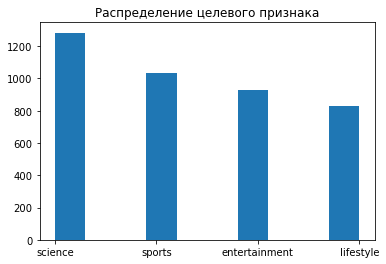

In [7]:
import matplotlib.pyplot as plt
plt.hist(targets)
plt.title('Распределение целевого признака')
plt.show()

## 3. С помощью моделей классического машинного обучения выполнить классификацию категорий собственного новостного корпуса. Добиться как можно лучшего качества. **Использовать минимум 6 методов (моделей)**

In [4]:
from sklearn.model_selection import train_test_split
X = values.toarray()
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2, random_state=42)

In [6]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

def evaluate(clf, X_test, y_true, with_prob=True):
    y_pred = clf.predict(X_test)
    print('Accuracy score: ', accuracy_score(y_true=y_true, y_pred=y_pred))
    #print('Precision score: ', precision_score(y_true=y_true, y_pred=y_pred))
    #print('Recall score: ', recall_score(y_true=y_true, y_pred=y_pred))
    print('F1 score: ', f1_score(y_true=y_true, y_pred=y_pred, average='weighted'))
    if with_prob:
        y_score = clf.predict_proba(X_test)
        print('ROC AUC score: ', roc_auc_score(y_true=y_true, y_score=y_score, average='weighted', multi_class='ovr'))

### Визуализация исходных данных
Попробуем сделать отображение векторов при помощи t-SNE и сделать какие-то выводы о группировке данных

In [21]:
data = pd.DataFrame(X, names=).assign(category = pd.Series(targets).values)

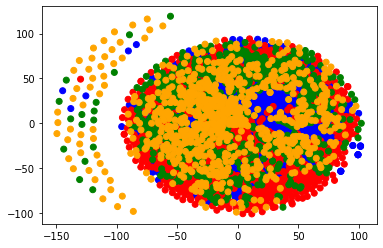

In [22]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop('category', axis=1))
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_scaled)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=data['category'].map({'science': 'blue', 'lifestyle': 'orange', 'sports': 'red', 'entertainment': 'green'}))

Получилось пасхальное яйцо, к сожалению никак не дающее предствление о данных 🙄

### Наивный Байесовский классификатор

Начнем с самой простой модели, а именно с наборов Наивных Байесовских классификаторов, основанных на применении теоремы Байеса с «наивным» предположением об условной независимости между каждой парой характеристик при заданном значении переменной класса. Различные наивные байесовские классификаторы различаются в основном предположениями, которые они делают относительно распределения $P(x_i | y)$

```GaussianNB``` реализует гауссовский наивный байесовский алгоритм для классификации:

In [7]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

evaluate(gnb, X_test, y_test)

Accuracy score:  0.8774509803921569
F1 score:  0.881046172637454
ROC AUC score:  0.922638751986578


Возьмем эти результаты как основу для дальнейшего исследования.

```MultinomialNB``` реализует наивный байесовский алгоритм для полиномиально распределенных данных и является одним из двух классических наивных байесовских вариантов, используемых в классификации текста:

In [26]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

evaluate(mnb, X_test, y_test)

Accuracy score:  0.9178921568627451
F1 score:  0.9127550375173319
ROC AUC score:  0.9894682410733668


В самом деле, были получены более высокие оценки.
Несмотря на то, что величина **ROC AUC** выглядит впечатляюще, наивный байесовский классификатор известен как приличный классификатор, он известен как плохой оценщик, поэтому к вероятностным выходным данным ```predict_proba()``` не следует относиться слишком серьезно, а именно они и используются при подсчете этой метрики.

Дополнение наивного Байеса ```ComplementNB``` является адаптацией стандартного полиномиального наивного байесовского алгоритма (MNB), который особенно подходит для несбалансированных наборов данных. В частности, CNB использует статистику из дополнения каждого класса для вычисления весов модели. Изобретатели CNB эмпирически показали, что оценки параметров для CNB более стабильны, чем для MNB. Кроме того, CNB регулярно превосходит MNB (часто со значительным отрывом) в задачах классификации текста. 

In [27]:
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB()
cnb.fit(X_train, y_train)

evaluate(cnb, X_test, y_test)

Accuracy score:  0.928921568627451
F1 score:  0.9259974524849578
ROC AUC score:  0.9896005123373515


И опять получили небольшое улучшение, что подтверждает слова создателей CNB.

### Модели на основе ближайших соседей

Принцип, лежащий в основе методов ближайшего соседа, состоит в том, чтобы найти предопределенное количество обучающих выборок, ближайших по расстоянию к новой точке, и предсказать метку по ним.

Первым будет **KNN**.
Основным параметром для его настройки является кол-во соседей, подберем его и оценим результат:

In [20]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors': [3, 5, 10],
            }

for p in params['n_neighbors']:
    knn = KNeighborsClassifier(n_neighbors=p)
    #clf = GridSearchCV(knn, params, scoring='accuracy', n_jobs=3, verbose=4, cv=3)
    #clf.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    print('N neighbors = ', p)
    evaluate(knn, X_test, y_test)

N neighbors =  3
Accuracy score:  0.9031862745098039
F1 score:  0.9032246159415873
ROC AUC score:  0.9682360537766017
N neighbors =  5
Accuracy score:  0.9129901960784313
F1 score:  0.9133811383254284
ROC AUC score:  0.9725979041449523
N neighbors =  10
Accuracy score:  0.9068627450980392
F1 score:  0.9069219232468839
ROC AUC score:  0.9830003454670441


По двум из трёх метрик лучше себя показывает значение параметра = 5.

### Логистическая регрессия

In [11]:
from sklearn.linear_model import LogisticRegression
lrc_1 = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='multinomial')
lrc_1.fit(X_train, y_train)
evaluate(lrc_1, X_test, y_test)

Accuracy score:  0.9473039215686274
F1 score:  0.9479624913283269
ROC AUC score:  0.9899619411194966


In [13]:
lrc_2 = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr')
lrc_2.fit(X_train, y_train)
evaluate(lrc_2, X_test, y_test)

Accuracy score:  0.9497549019607843
F1 score:  0.9500623511150059
ROC AUC score:  0.9903588255077491


In [14]:
lrc_3 = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')
lrc_3.fit(X_train, y_train)
evaluate(lrc_3, X_test, y_test)

Accuracy score:  0.928921568627451
F1 score:  0.9296169554541266
ROC AUC score:  0.9885535004261028


In [16]:
lrc_4 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
lrc_4.fit(X_train, y_train)
evaluate(lrc_4, X_test, y_test)

Accuracy score:  0.9411764705882353
F1 score:  0.9422282581525576
ROC AUC score:  0.9895916927819635


### Дерево решений

In [17]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='gini')
dtc.fit(X_train, y_train)
evaluate(dtc, X_test, y_test)

Accuracy score:  0.9117647058823529
F1 score:  0.9121524589355958
ROC AUC score:  0.9426541200797914


In [34]:
dtc_e = DecisionTreeClassifier(criterion='entropy')
dtc_e.fit(X_train, y_train)
evaluate(dtc_e, X_test, y_test)

Accuracy score:  0.9203431372549019
F1 score:  0.9206688905050291
ROC AUC score:  0.9525319055530053


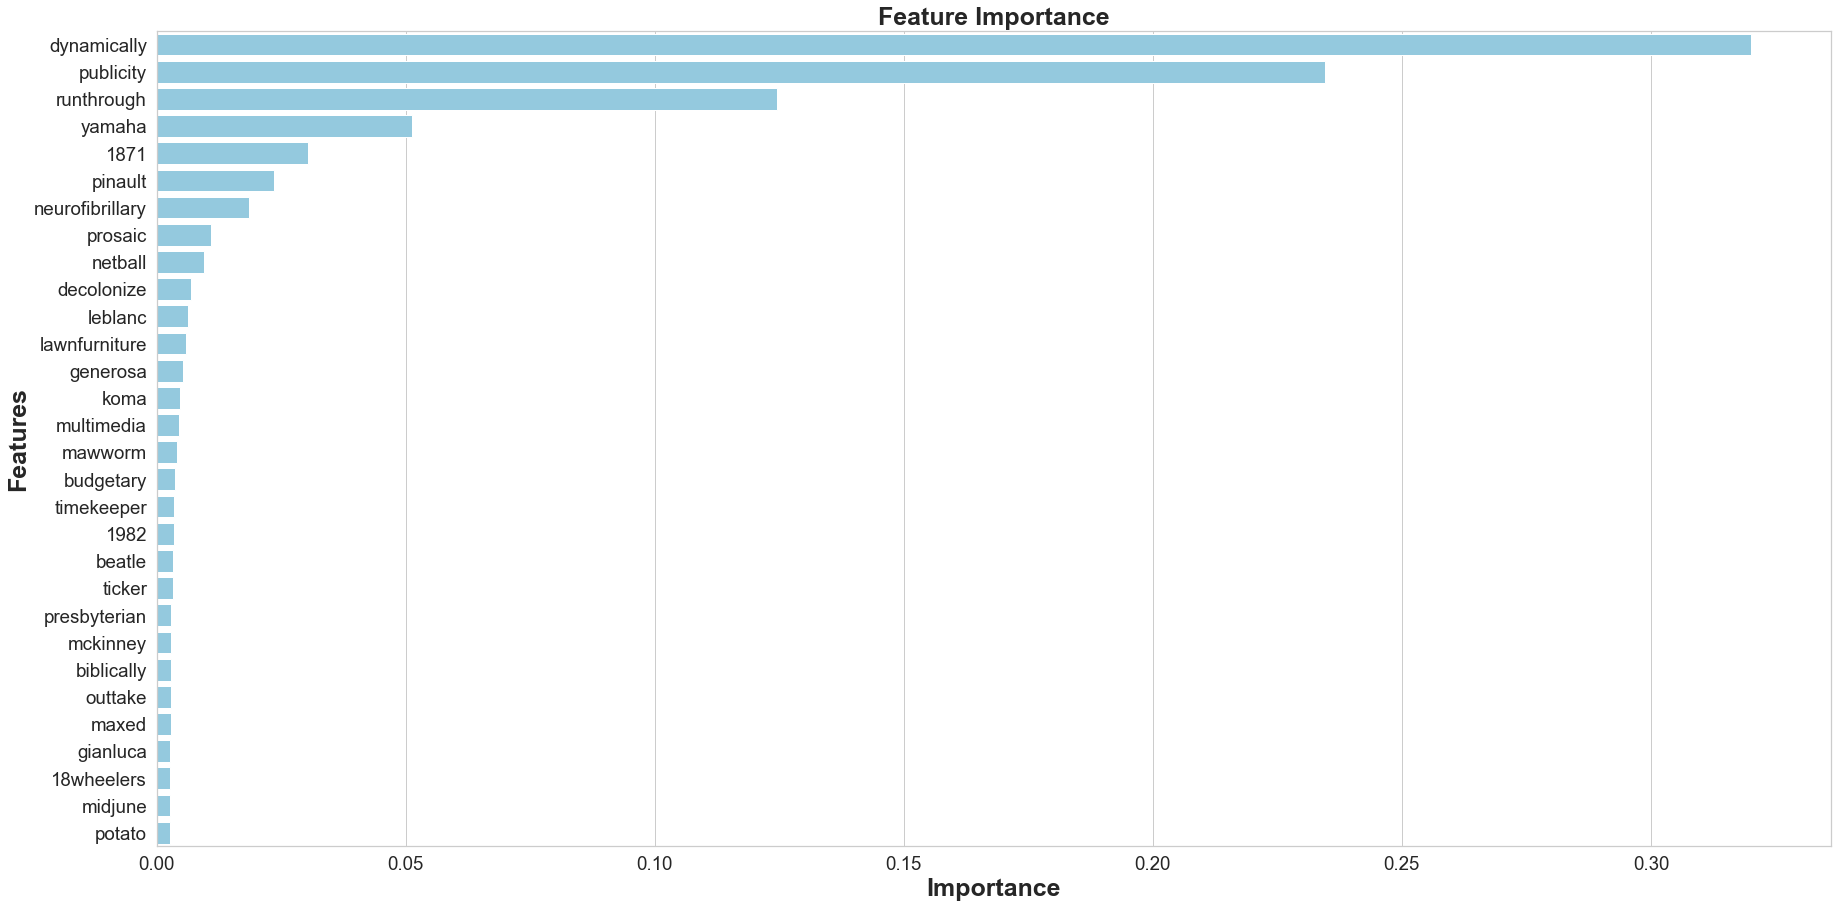

None

,Features,Gini-Importance
0,dynamically,0.320050
1,publicity,0.234487
2,runthrough,0.124483
3,yamaha,0.051241
4,1871,0.030453
5,pinault,0.023548
6,neurofibrillary,0.018575
7,prosaic,0.010829
8,netball,0.009512
9,decolonize,0.006904


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
feats = {}
for feature, importance in zip(tfidf_vectorizer.vocabulary_.keys(), dtc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances = importances[:30]
#importances["Gini-Importance"] = importances["Gini-Importance"].apply(lambda x: x * 10)
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

### Матрица ошибок

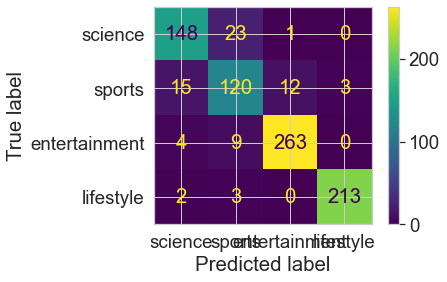

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = dtc.predict(X_test)
conf_matrix_baseline = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(conf_matrix_baseline, display_labels=['science', 'sports', 'entertainment', 'lifestyle'])
cmd.plot()

Посмотрев на матрицу можно сделать следующие выводы:

- Категории "наука" и "спорт" определяются хуже остальных, хотя количество элементов этой категории несколько выше(см. гистограмму выше)
- Категории "наука" и "спорт" наиболее часто перепутываются друг с другом.
- Также немного путаются "спорт" и "развлечения"

### Модели на методе опорных векторов (SVC)

In [7]:
from sklearn.svm import SVC

svc = SVC(kernel='linear') # linear
svc.fit(X_train, y_train)
evaluate(svc, X_test, y_test, with_prob=False)

Accuracy score:  0.946078431372549
F1 score:  0.9466846146293488


In [8]:
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_train, y_train)
evaluate(svc_poly, X_test, y_test, with_prob=False)

Accuracy score:  0.8443627450980392
F1 score:  0.8559928898239479


In [9]:
from sklearn.svm import NuSVC

nusvc = NuSVC(kernel='linear')
nusvc.fit(X_train, y_train)
evaluate(nusvc, X_test, y_test, with_prob=False)

Accuracy score:  0.9301470588235294
F1 score:  0.9319861476641037


### Случайный лес

In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy')
rfc.fit(X_train, y_train)
evaluate(rfc, X_test, y_test)

Accuracy score:  0.9411764705882353
F1 score:  0.940818455984273
ROC AUC score:  0.9813961309232515


In [39]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, criterion='gini')
rfc.fit(X_train, y_train)
evaluate(rfc, X_test, y_test)

Accuracy score:  0.9387254901960784
F1 score:  0.9380180619927927
ROC AUC score:  0.9820261591174849


## Итоговые результаты

In [44]:
results = {'NaiveBias' : [0.929, 0.926, 0.990],
            'KNN' : [0.913, 0.913, 0.973],
            'LogRegr' : [0.950, 0.950, 0.990],
            'DecTree' : [0.920, 0.920, 0.956],
            'SVC' : [0.946, 0.947, None],
            'RandomForest' : [0.941, 0.941, 0.981]}

results_df = pd.DataFrame(results, index=['Accuracy', 'F-1', 'ROC AUC'])
results_df

,NaiveBias,KNN,LogRegr,DecTree,SVC,RandomForest
Accuracy,0.929,0.913,0.95,0.920,0.946,0.941
F-1,0.926,0.913,0.95,0.920,0.947,0.941
ROC AUC,0.990,0.973,0.99,0.956,NaN,0.981


Как можно заметить, лучше всего себя проявили Логистическая регрессия и SVC.